In [1]:
import qiskit
import math
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, BasicAer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCXGate 
from numpy import pi

# Choice of the Clause

In [59]:
expr = np.array([[1, -2, 3], [2, -3, 4], [-3, -4, 5]])

In [60]:
n = 5 # n variables
m = 3 # num of clauses
m_upper = math.ceil(math.log2(m+1))
num_assignments = 2**n

In [61]:
def transform_expression(expression):
    new_repr = []
    for clause in expression:
        new_repr.append((False, [(True, abs(var) - 1) if var < 0 else (False, var - 1) for var in clause]))
    return new_repr

In [62]:
expression = transform_expression(expr)
print(expression)

[(False, [(False, 0), (True, 1), (False, 2)]), (False, [(False, 1), (True, 2), (False, 3)]), (False, [(True, 2), (True, 3), (False, 4)])]


# 1-in-P SAT Clauses (Shrinking of the Space possible)

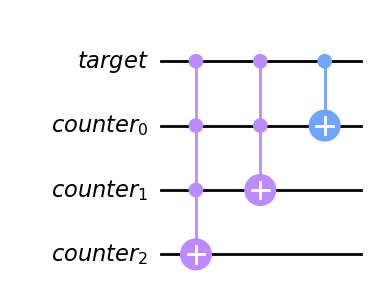

In [63]:
def get_toffoli_counter(m_upper):
    """
    counts +1 for the counting qubits if a clause is satisfied
    """
    q_var = QuantumRegister(m_upper, name='counter')
    q_target = QuantumRegister(1, 'target')
    counter = QuantumCircuit(q_target, q_var, name='counter')  
    
    for i in range(m_upper):
        counter.append(MCXGate(m_upper-i), q_target[0:]+q_var[0:m_upper-i])
    return counter

get_toffoli_counter(3).draw('mpl')

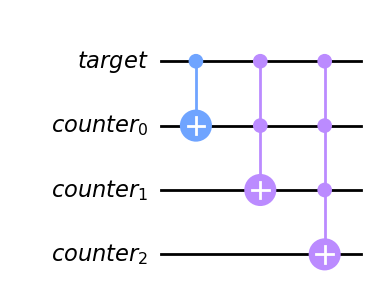

In [64]:
def get_reverse_toffoli_counter(m_upper):
    """
    counts -1 for the counting qubits if a clause is satisfied
    """
    q_var = QuantumRegister(m_upper, name='counter')
    q_target = QuantumRegister(1, name='target')
    counter = QuantumCircuit(q_target, q_var, name='rev_counter')  
    
    for i in range(m_upper):
        counter.append(MCXGate(i+1), q_target[0:]+q_var[0:(i+1)])
    return counter

get_reverse_toffoli_counter(3).draw('mpl')

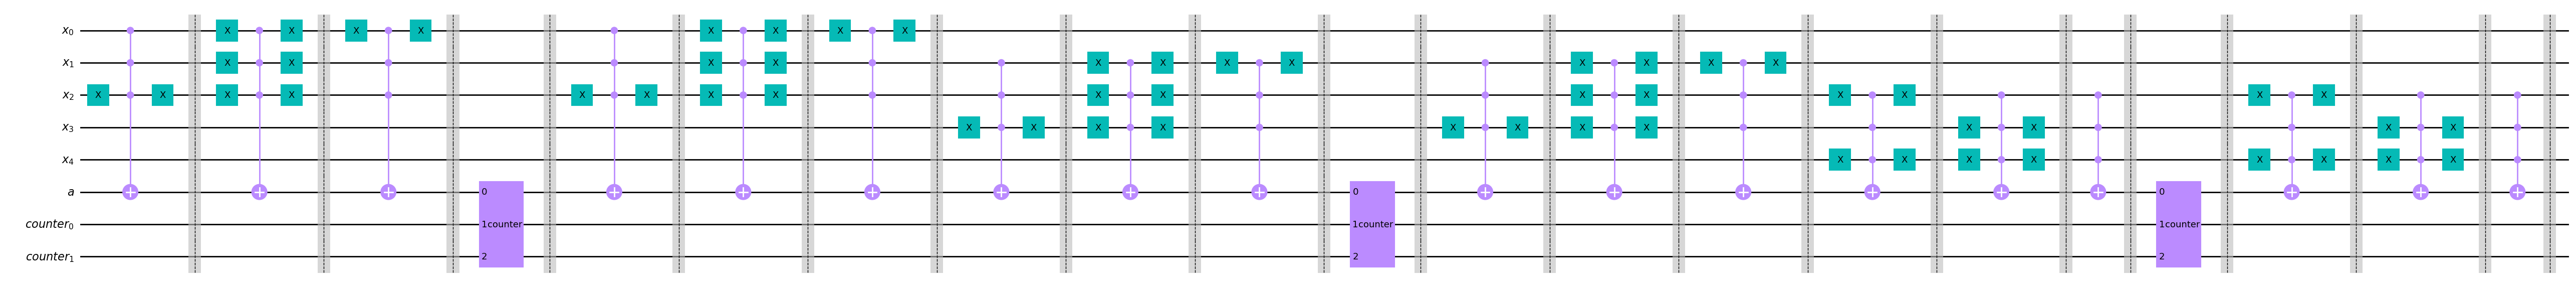

In [65]:
def get_oracle(expression, n, m_upper, m):
    """
    oracle for 1inp-SAT expression. 
    """
    m = len(expression)
    x_vars = QuantumRegister(n, name='x')
    a_var = QuantumRegister(1, name='a')
    #w_var = QuantumRegister(1, name='w')
    counter_vars = QuantumRegister(m_upper, name='counter')
    oracle = QuantumCircuit(x_vars, a_var, counter_vars, name='oracle')
    
    for i, val in enumerate(expression):       
        nc, clause = val
                
        clause_qubits = [x_vars[var_index] for nv, var_index in clause] 
        
        num_clause_qubits = len(clause_qubits)
        
        for i in range(num_clause_qubits): # only one variable out of all clause variables can be true 
            i = clause[i][1] 
            for nv, var_index in clause:
                if not(nv) and var_index!=i:
                    oracle.x(x_vars[var_index])
                if var_index==i:
                    if nv:
                        oracle.x(x_vars[var_index])
                        
            oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [a_var[0]])
            
            for nv, var_index in clause:
                if not(nv) and var_index!=i:
                    oracle.x(x_vars[var_index])
                if var_index==i:
                    if nv:
                        oracle.x(x_vars[var_index])
            oracle.barrier()
        
        #oracle.cx(a_var[0], w_var[0])
        
        # counter 
        oracle.append(get_toffoli_counter(m_upper), a_var[0:] + counter_vars[0:])
        
        #oracle.cx(a_var[0], w_var[0])
        
        oracle.barrier()
        
        for i in range(num_clause_qubits):
            i = clause[i][1]
            for nv, var_index in reversed(clause):
                if not(nv) and var_index!=i:
                    oracle.x(x_vars[var_index])
                if var_index==i:
                    if nv:
                        oracle.x(x_vars[var_index])
                        
            oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [a_var[0]])
            
            for nv, var_index in reversed(clause):
                if not(nv) and var_index!=i:
                    oracle.x(x_vars[var_index])
                if var_index==i:
                    if nv:
                        oracle.x(x_vars[var_index])
            oracle.barrier()

    return oracle 

# TODO: Wenn die Clause gefinished ist dann muss ich sie wieder rückgängig machen. Das funktioniert gerade noch nicht
get_oracle(expression, n, m_upper, m).draw('mpl', fold=-1) #[ 1, -2,  3, -5] -> x on 2 and x on 5 (We want only 1 to be satisfied)

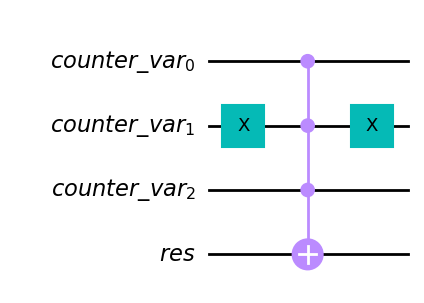

In [66]:
def get_result(m_upper, m):
    counter_vars = QuantumRegister(m_upper, name = 'counter_var')
    res_var = QuantumRegister(1, name = 'res')
    qc = QuantumCircuit(counter_vars, res_var, name='get_result')
    
    for c_num, j in enumerate(bin(m)[2:][::-1]):
        if int(j) == 0:
            qc.x(counter_vars[c_num])

    if len(bin(m)[2:]) < m_upper:
        for i in range(m_upper - len(bin(m)[2:])):
            qc.x(counter_vars[m_upper-1-i])
    
    qc.append(MCXGate(m_upper), counter_vars[0:] + [res_var[0]])
    
    if len(bin(m)[2:]) < m_upper:
        for i in range(m_upper - len(bin(m)[2:])):
            qc.x(counter_vars[m_upper-1-i])

    for c_num, j in enumerate(bin(m)[2:][::-1]):
        if int(j) == 0:
            qc.x(counter_vars[c_num])
    
    return qc

get_result(3, 5).draw('mpl')

In [67]:
def get_reversed_oracle(expression, n, m_upper, m):
    """
    oracle for 1inp-SAT expression. 
    """
    m = len(expression)
    x_vars = QuantumRegister(n, name='x')
    a_var = QuantumRegister(1, name='a')
    #w_var = QuantumRegister(1, name='w')
    counter_vars = QuantumRegister(m_upper, name='rev_counter')
    oracle = QuantumCircuit(x_vars, a_var, counter_vars, name='oracle')
    
    for i, val in enumerate(expression):       
        nc, clause = val
                
        clause_qubits = [x_vars[var_index] for nv, var_index in clause] 
        
        num_clause_qubits = len(clause_qubits)
        
        for i in range(num_clause_qubits): # only one variable out of all clause variables can be true 
            i = clause[i][1] 
            for nv, var_index in clause:
                if not(nv) and var_index!=i:
                    oracle.x(x_vars[var_index])
                if var_index==i:
                    if nv:
                        oracle.x(x_vars[var_index])
                        
            oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [a_var[0]])
            
            for nv, var_index in clause:
                if not(nv) and var_index!=i:
                    oracle.x(x_vars[var_index])
                if var_index==i:
                    if nv:
                        oracle.x(x_vars[var_index])
            oracle.barrier()
        
        #oracle.cx(a_var[0], w_var[0])
        
        # rev_counter 
        oracle.append(get_reverse_toffoli_counter(m_upper), a_var[0:] + counter_vars[0:])
        
        #oracle.cx(a_var[0], w_var[0])
        
        oracle.barrier()
        
        for i in range(num_clause_qubits):
            i = clause[i][1]
            for nv, var_index in reversed(clause):
                if not(nv) and var_index!=i:
                    oracle.x(x_vars[var_index])
                if var_index==i:
                    if nv:
                        oracle.x(x_vars[var_index])
                        
            oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [a_var[0]])
            
            for nv, var_index in reversed(clause):
                if not(nv) and var_index!=i:
                    oracle.x(x_vars[var_index])
                if var_index==i:
                    if nv:
                        oracle.x(x_vars[var_index])
            oracle.barrier()

    return oracle 

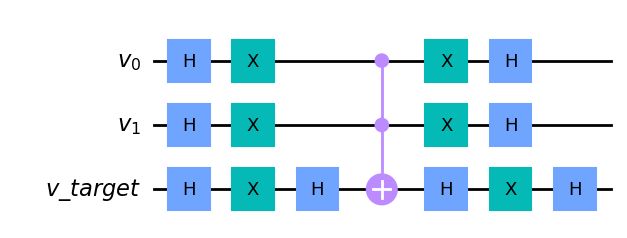

In [68]:
def get_diffuser(k):
    """
    Amplifies the solution(s). We safe the result of the expression (1 True, 0 False) in res_var[-1] which
    gets checked.
    """
    q_var = QuantumRegister(k, name='v')
    q_target = QuantumRegister(1, name='v_target')
    diffuser = QuantumCircuit(q_var, q_target, name='diffuser')    
    diffuser.h(q_var)
    diffuser.x(q_var)
    diffuser.h(q_target)
    diffuser.x(q_target)
    diffuser.h(q_target)
    diffuser.append(MCXGate(k), q_var[0:]+q_target[0:])
    diffuser.h(q_target)
    diffuser.x(q_target)
    diffuser.h(q_target)
    diffuser.x(q_var)
    diffuser.h(q_var)
    return diffuser

get_diffuser(2).draw('mpl')

In [69]:
x_var = QuantumRegister(n, 'x')
a_var = QuantumRegister(1, 'a')
w_var = QuantumRegister(1, 'w')
counter_vars = QuantumRegister(m_upper, 'counter')
res_var = QuantumRegister(1, 'res')
answer_var = ClassicalRegister(n, 'answer') # want to measure v and the q_checker if the 3SAT problem is satisfied
qc = QuantumCircuit(x_var, w_var, counter_vars, res_var, answer_var)

In [70]:
repetitions = 1

qc.h(x_var)

qc.x(res_var)
qc.h(res_var)

qc.barrier()

for i in range(repetitions): 
    qc.append(get_oracle(expression, n, m_upper, m), x_var[0:] + w_var[0:] + counter_vars[0:])
    qc.barrier()
    
    qc.append(get_result(m_upper, m), counter_vars[0:] + res_var[0:])
    qc.barrier()
    
    qc.append(get_reversed_oracle(expression, n, m_upper, m), x_var[0:] + w_var[0:] + counter_vars[0:])
    qc.barrier()
    
    qc.append(get_diffuser(n-1), x_var[0:])
    qc.barrier()

In [71]:
qc.measure(x_var, range(n))

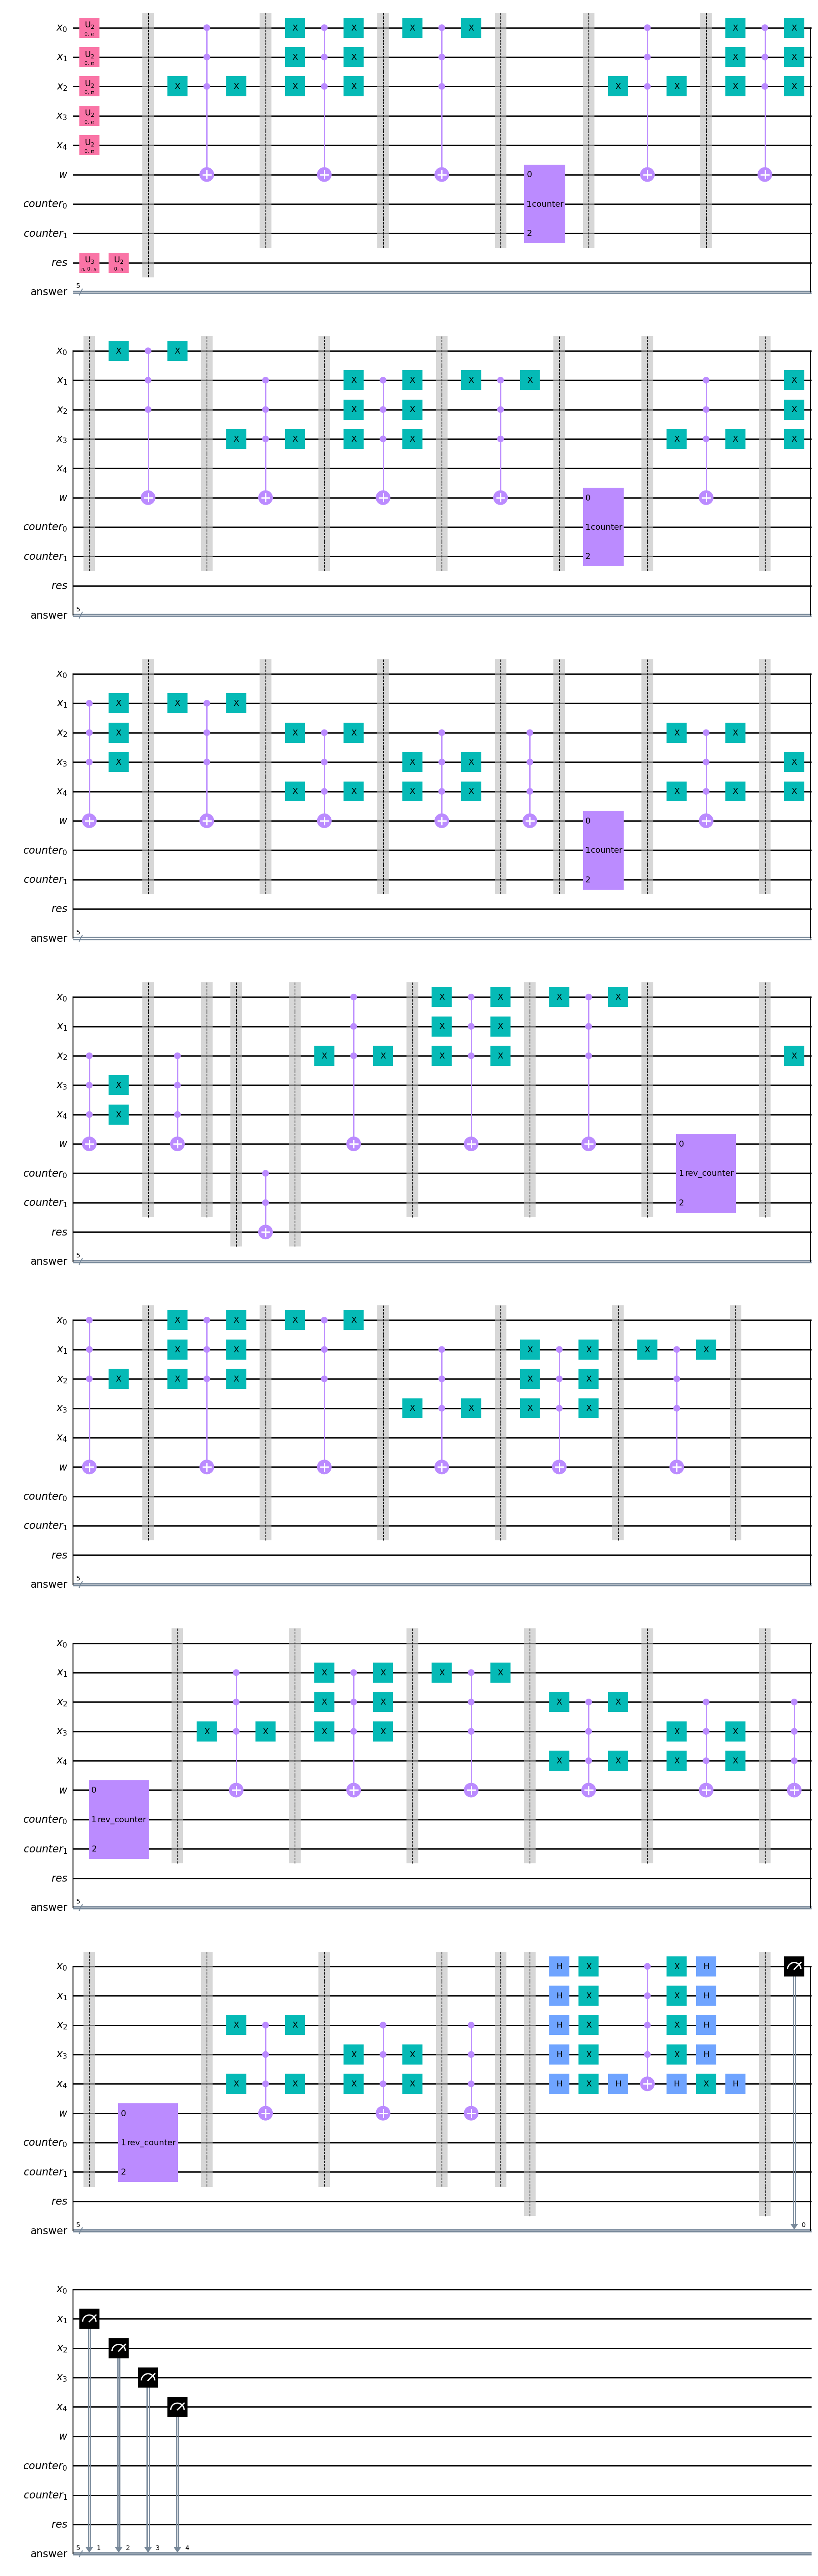

In [72]:
qc.decompose().draw('mpl') 

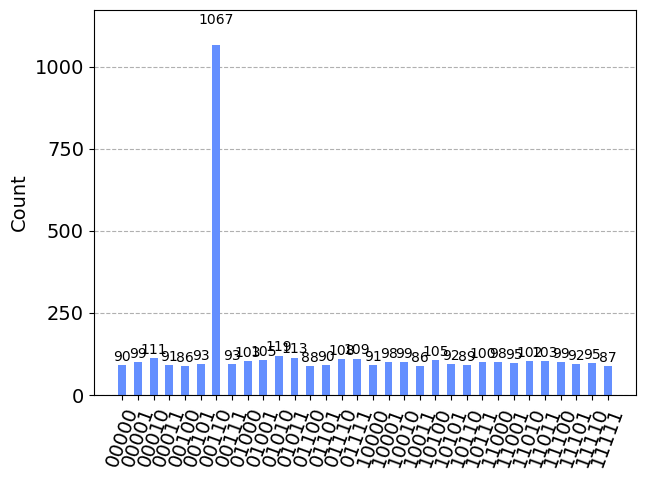

In [73]:
num_shots = 4096

simulator = BasicAer.get_backend('qasm_simulator')
result = execute(qc, simulator, shots=num_shots).result()
counts = result.get_counts(qc)  
plot_histogram(counts) 

In [74]:
mean = num_shots / num_assignments
confidence_rate = 1.5

solutions = [key for key, value in counts.items() if value > int(confidence_rate * mean)]
solutions = [solution[::-1] for solution in solutions]
print(solutions)

['01100']


In [77]:
import itertools

subspace = list(itertools.product([0, 1], repeat=n))

def varify_clause_q_in_p_SAT(assignment, expression, q):    
    for i, val in enumerate(expression):
        counter = 0
        nc, clause = val
        for nv, var_index in clause:
            if nv:
                if assignment[var_index] == 0:
                    counter += 1
            else:
                if assignment[var_index] == 1:
                    counter += 1
        if counter != q:
            return f'False: error in clause {i}.'
    return 'True.'

# 10 here means 01 in the output of the program!

for solution in solutions:
    tested_expr_index = int(solution, 2)
    tested_expr = subspace[tested_expr_index] 
    print(tested_expr)
    print(varify_clause_q_in_p_SAT(tested_expr, expression, 1))

(0, 1, 1, 0, 0)
True.


# SAT clauses

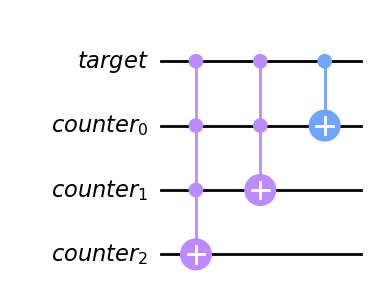

In [17]:
def get_toffoli_counter(m_upper):
    """
    counts +1 for the counting qubits if a clause is satisfied
    """
    q_var = QuantumRegister(m_upper, name='counter')
    q_target = QuantumRegister(1, 'target')
    counter = QuantumCircuit(q_target, q_var, name='counter')  
    
    for i in range(m_upper):
        counter.append(MCXGate(m_upper-i), q_target[0:]+q_var[0:m_upper-i])
    return counter

get_toffoli_counter(3).draw('mpl')

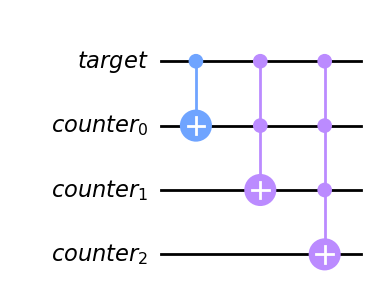

In [18]:
def get_reverse_toffoli_counter(m_upper):
    """
    counts -1 for the counting qubits if a clause is satisfied
    """
    q_var = QuantumRegister(m_upper, name='counter')
    q_target = QuantumRegister(1, name='target')
    counter = QuantumCircuit(q_target, q_var, name='rev_counter')  
    
    for i in range(m_upper):
        counter.append(MCXGate(i+1), q_target[0:]+q_var[0:(i+1)])
    return counter

get_reverse_toffoli_counter(3).draw('mpl')

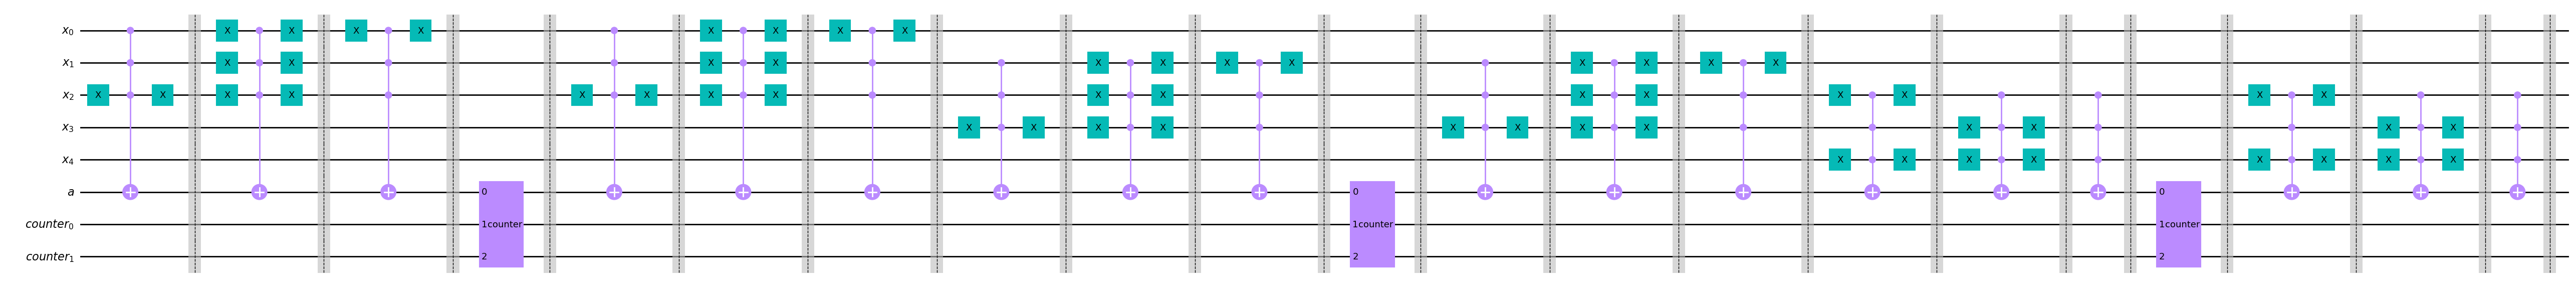

In [19]:
def get_sat_oracle(expression, n, m_upper, m):
    """
    oracle for 1inp-SAT expression. 
    """
    m = len(expression)
    x_vars = QuantumRegister(n, name='x')
    a_var = QuantumRegister(1, name='a')
    counter_vars = QuantumRegister(m_upper, name='counter')
    oracle = QuantumCircuit(x_vars, a_var, counter_vars, name='oracle')
    
    for i, val in enumerate(expression):       
        nc, clause = val
                
        clause_qubits = [x_vars[var_index] for nv, var_index in clause] 
        
        num_clause_qubits = len(clause_qubits)

        for nv, var_index in clause:
            if not(nv):
                oracle.x(x_vars[var_index])

        oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [a_var[0]])

        for nv, var_index in clause:
            if not(nv):
                oracle.x(x_vars[var_index])
                    
        oracle.barrier()
        
        # counter 
        oracle.append(get_toffoli_counter(m_upper), a_var[0:] + counter_vars[0:])
        
        oracle.barrier()
        
        for nv, var_index in reversed(clause):
            if not(nv):
                oracle.x(x_vars[var_index])

        oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [a_var[0]])

        for nv, var_index in reversed(clause):
            if not(nv):
                oracle.x(x_vars[var_index])

        oracle.barrier()

    return oracle 

# TODO: Wenn die Clause gefinished ist dann muss ich sie wieder rückgängig machen. Das funktioniert gerade noch nicht
get_oracle(expression, n, m_upper, m).draw('mpl', fold=-1)

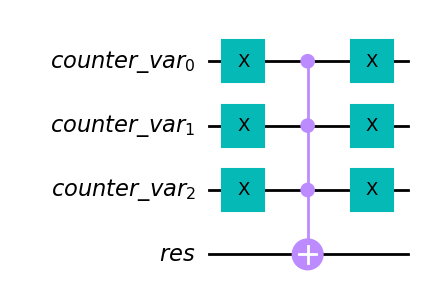

In [20]:
def get_sat_result(m_upper, m):
    counter_vars = QuantumRegister(m_upper, name = 'counter_var')
    res_var = QuantumRegister(1, name = 'res')
    qc = QuantumCircuit(counter_vars, res_var, name='get_result')
    
    for c_num, j in enumerate(bin(m)[2:][::-1]):
        qc.x(counter_vars[c_num])
    
    qc.append(MCXGate(m_upper), counter_vars[0:] + [res_var[0]])

    for c_num, j in enumerate(bin(m)[2:][::-1]):
        qc.x(counter_vars[c_num])
    
    return qc

get_sat_result(3, 5).draw('mpl')   

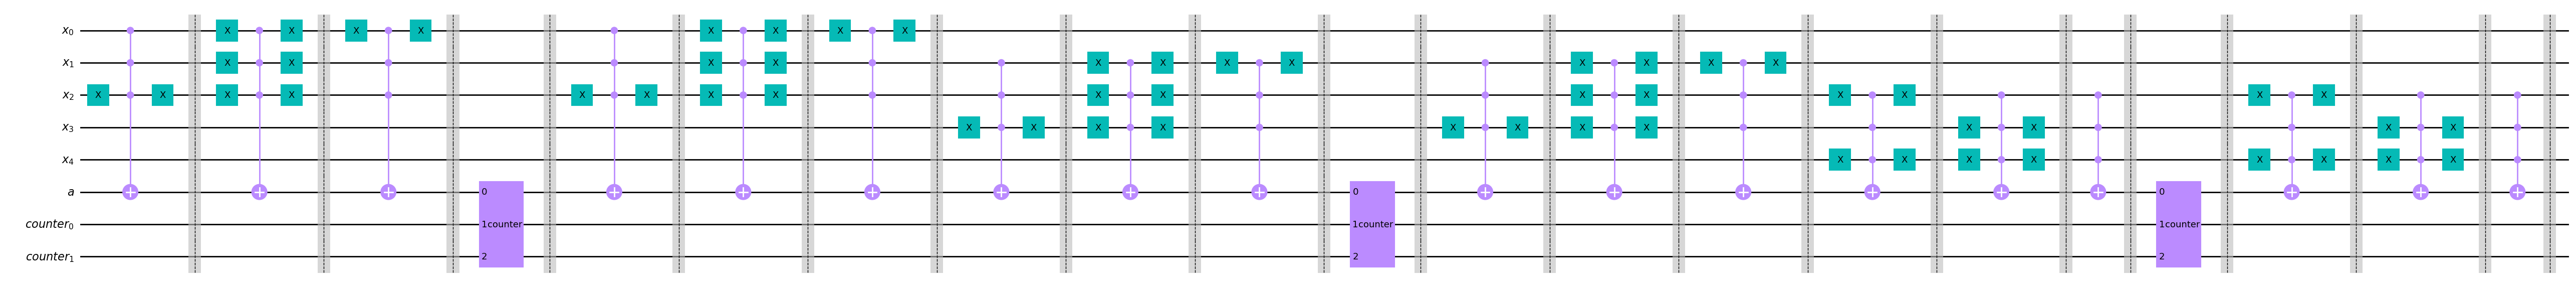

In [21]:
def get_reversed_sat_oracle(expression, n, m_upper, m):
    """
    oracle for 1inp-SAT expression. 
    """
    m = len(expression)
    x_vars = QuantumRegister(n, name='x')
    a_var = QuantumRegister(1, name='a')
    counter_vars = QuantumRegister(m_upper, name='counter')
    oracle = QuantumCircuit(x_vars, a_var, counter_vars, name='oracle')
    
    for i, val in enumerate(expression):       
        nc, clause = val
                
        clause_qubits = [x_vars[var_index] for nv, var_index in clause] 

        for nv, var_index in clause:
            if not(nv):
                oracle.x(x_vars[var_index])

        oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [a_var[0]])

        for nv, var_index in clause:
            if not(nv):
                oracle.x(x_vars[var_index])
                    
        oracle.barrier()
        
        # counter 
        oracle.append(get_reverse_toffoli_counter(m_upper), a_var[0:] + counter_vars[0:])
        
        oracle.barrier()
        
        for nv, var_index in reversed(clause):
            if not(nv):
                oracle.x(x_vars[var_index])

        oracle.append(MCXGate(len(clause_qubits)), clause_qubits + [a_var[0]])

        for nv, var_index in reversed(clause):
            if not(nv):
                oracle.x(x_vars[var_index])

        oracle.barrier()

    return oracle 

# TODO: Wenn die Clause gefinished ist dann muss ich sie wieder rückgängig machen. Das funktioniert gerade noch nicht
get_oracle(expression, n, m_upper, m).draw('mpl', fold=-1)

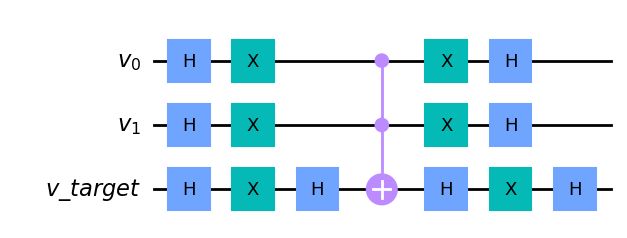

In [22]:
 def get_diffuser(k):
    """
    Amplifies the solution(s). We safe the result of the expression (1 True, 0 False) in res_var[-1] which
    gets checked.
    """
    q_var = QuantumRegister(k, name='v')
    q_target = QuantumRegister(1, name='v_target')
    diffuser = QuantumCircuit(q_var, q_target, name='diffuser')    
    diffuser.h(q_var)
    diffuser.x(q_var)
    diffuser.h(q_target)
    diffuser.x(q_target)
    diffuser.h(q_target)
    diffuser.append(MCXGate(k), q_var[0:]+q_target[0:])
    diffuser.h(q_target)
    diffuser.x(q_target)
    diffuser.h(q_target)
    diffuser.x(q_var)
    diffuser.h(q_var)
    return diffuser

get_diffuser(2).draw('mpl')

In [23]:
x_var = QuantumRegister(n, 'x')
a_var = QuantumRegister(1, 'a')
w_var = QuantumRegister(1, 'w')
counter_vars = QuantumRegister(m_upper, 'counter')
res_var = QuantumRegister(1, 'res')
answer_var = ClassicalRegister(n, 'answer') # want to measure v and the q_checker if the 3SAT problem is satisfied
qc = QuantumCircuit(x_var, w_var, counter_vars, res_var, answer_var)

In [24]:
repetitions = 1

qc.h(x_var)

qc.x(res_var)
qc.h(res_var)

qc.barrier()

for i in range(repetitions): # I removed the a_var
    qc.append(get_sat_oracle(expression, n, m_upper, m), x_var[0:] + w_var[0:] + counter_vars[0:])
    qc.barrier()
    
    qc.append(get_sat_result(m_upper, m), counter_vars[0:] + res_var[0:])
    qc.barrier()
    
    qc.append(get_reversed_sat_oracle(expression, n, m_upper, m), x_var[0:] + w_var[0:] + counter_vars[0:])
    qc.barrier()
    
    qc.append(get_diffuser(n-1), x_var[0:])
    qc.barrier()

In [25]:
qc.measure(x_var, range(n))

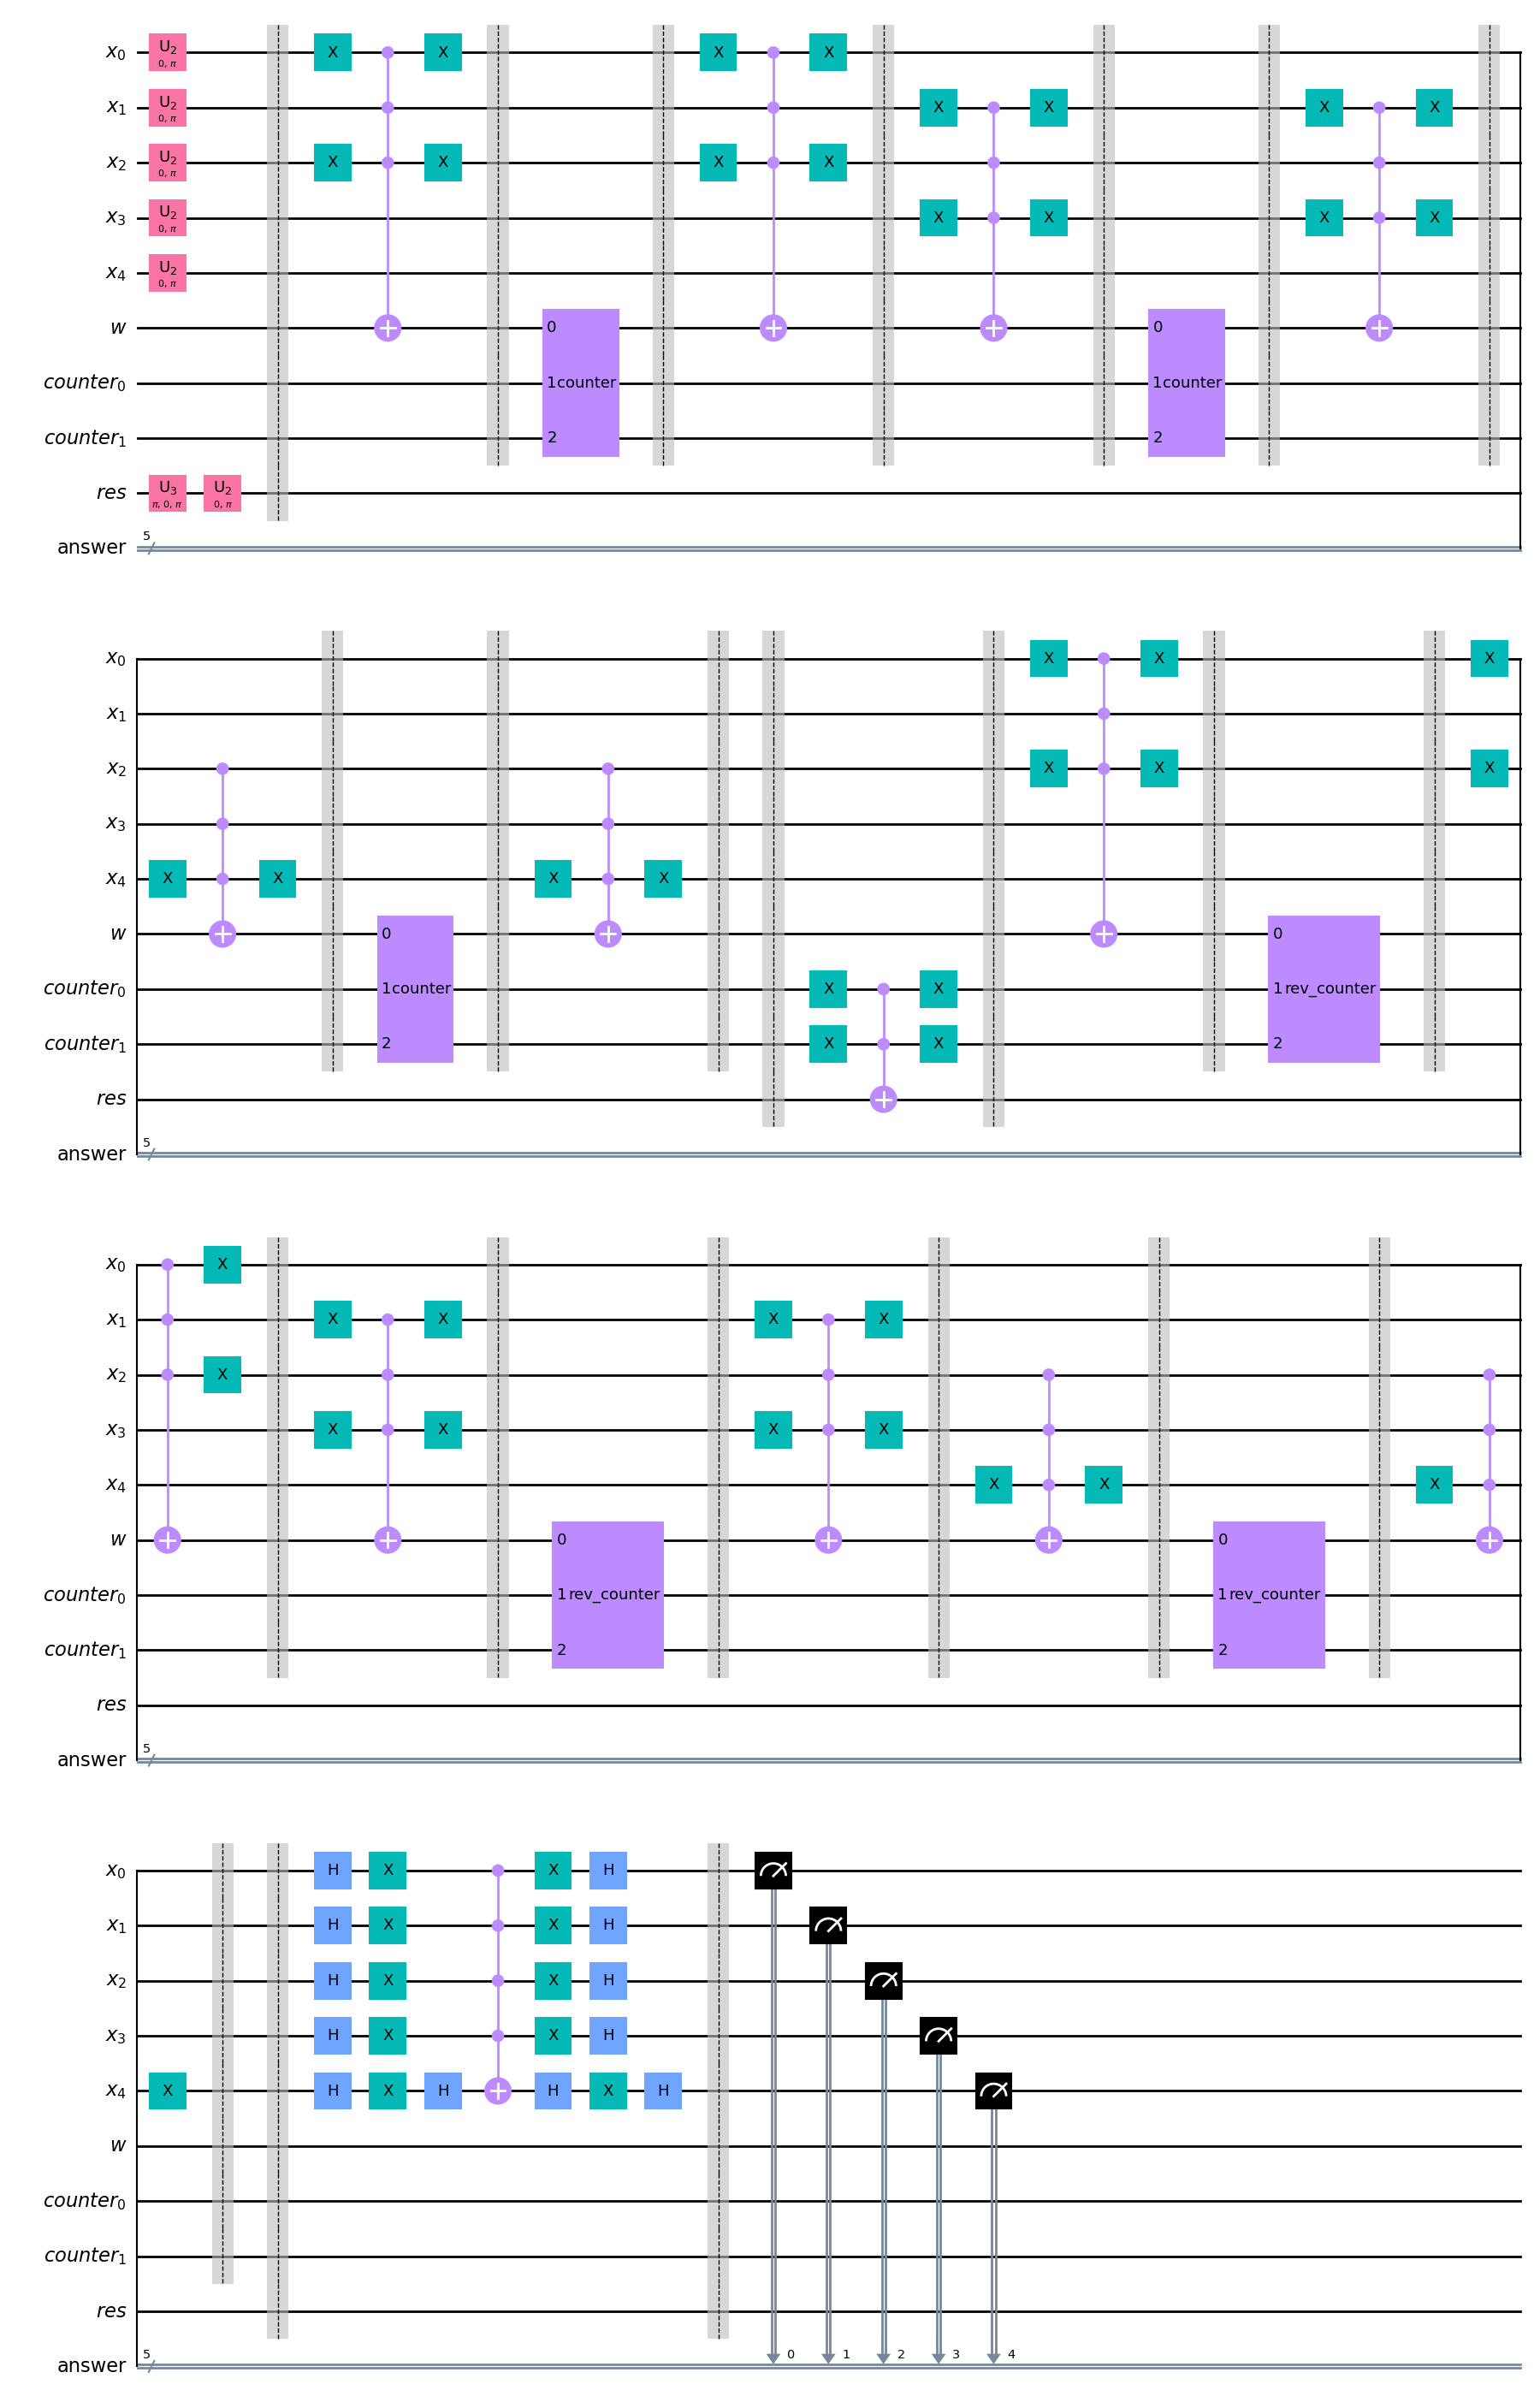

In [26]:
qc.decompose().draw('mpl') 

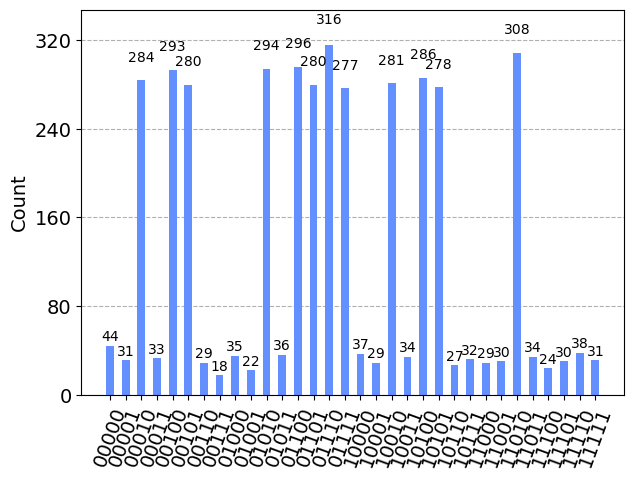

In [33]:
num_shots = 4096

simulator = BasicAer.get_backend('qasm_simulator')
result = execute(qc, simulator, shots=num_shots).result()
counts = result.get_counts(qc)  
plot_histogram(counts) 

This is a great example, where the number of solutions is greater than half the number of total assignments. We have 20 good assignments and 12 bad assignments. Therefore the bad assignments are amplified. We simply have to take the opposite of those assignments and get our solutions. 

In [55]:
mean = num_shots / num_assignments
confidence_rate = 1.5

solutions = [key for key, value in counts.items() if value > int(confidence_rate * mean)]
solutions = [solution[::-1] for solution in solutions]
print(solutions)

['10101', '11110', '10110', '10100', '01110', '01001', '01010', '01011', '00110', '00101', '00100', '01000']


In [56]:
import itertools

subspace = list(itertools.product([0, 1], repeat=n))

def varify_clause_SAT(assignment, expression, q):    
    for i, val in enumerate(expression):
        counter = 0
        nc, clause = val
        for nv, var_index in clause:
            if nv:
                if assignment[var_index] == 0:
                    counter += 1
            else:
                if assignment[var_index] == 1:
                    counter += 1
        if counter == 0:
            return f'False: error in clause {i}.'
    return 'True.'

# 10 here means 01 in the output of the program!

for solution in solutions:
    tested_expr_index = int(solution, 2)
    tested_expr = subspace[tested_expr_index] 
    print(tested_expr)
    print(varify_clause_SAT(tested_expr, expression, 1))

(1, 0, 1, 0, 1)
False: error in clause 1.
(1, 1, 1, 1, 0)
False: error in clause 2.
(1, 0, 1, 1, 0)
False: error in clause 2.
(1, 0, 1, 0, 0)
False: error in clause 1.
(0, 1, 1, 1, 0)
False: error in clause 2.
(0, 1, 0, 0, 1)
False: error in clause 0.
(0, 1, 0, 1, 0)
False: error in clause 0.
(0, 1, 0, 1, 1)
False: error in clause 0.
(0, 0, 1, 1, 0)
False: error in clause 2.
(0, 0, 1, 0, 1)
False: error in clause 1.
(0, 0, 1, 0, 0)
False: error in clause 1.
(0, 1, 0, 0, 0)
False: error in clause 0.
